In [1]:
import os
import datetime
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
%matplotlib inline

# 1. Get data

Data source: https://quantquote.com/historical-stock-data

In [3]:
sorted(list(filter(lambda f: not f.startswith("."), os.listdir("."))))

['Pandas Tutorial.ipynb',
 'Pandas Tutorial.pdf',
 'Python Pandas Tutorial.docx',
 'Time Series Analysis.ipynb',
 'Untitled.ipynb',
 'chipotle.txt',
 'drinks.csv',
 'imdb.csv',
 'movieusers.txt',
 'quantquote_daily_sp500_83986',
 'ufo.csv']

In [4]:
def get_data(data_url):
    with requests.get(data_url) as r:

        with zipfile.ZipFile(io.BytesIO(r.content)) as z:
            z.extractall()

In [5]:
data_url = "http://quantquote.com/files/quantquote_daily_sp500_83986.zip"

In [6]:
get_data(data_url=data_url)

In [7]:
data_dir = os.path.join("quantquote_daily_sp500_83986", "daily")

In [8]:
len(os.listdir(data_dir))

500

## Scope out data directory

In [9]:
stock_csv_names = sorted(os.listdir(data_dir))

In [10]:
len(stock_csv_names)

500

In [11]:
stock_csv_names[:5]

['table_a.csv',
 'table_aa.csv',
 'table_aapl.csv',
 'table_abbv.csv',
 'table_abc.csv']

In [12]:
cols = ['date', 'time', 'open', 'high', 'low_price', 'close', 'volume']

## Look at sample of data

In [13]:
a_df = pd.read_csv(os.path.join(data_dir, stock_csv_names[0]),
                   names=cols)

In [14]:
a_df.shape

(3452, 7)

In [15]:
a_df.head()

,date,time,open,high,low_price,close,volume
0,19991118,0,42.2076,46.3820,37.4581,39.1928,4.398181e+07
1,19991119,0,39.8329,39.8885,36.9293,37.6251,1.139020e+07
2,19991122,0,38.3208,40.0091,37.1613,39.9442,4.654716e+06
3,19991123,0,39.4247,40.4729,37.3375,37.5138,4.268903e+06
4,19991124,0,37.2262,38.9052,37.1056,38.0889,3.602367e+06


In [16]:
a_df.dtypes

date           int64
time           int64
open         float64
high         float64
low_price    float64
close        float64
volume       float64
dtype: object

In [17]:
a_df.isnull().sum()

date         0
time         0
open         0
high         0
low_price    0
close        0
volume       0
dtype: int64

In [18]:
a_df.duplicated().sum()

0

In [19]:
a_df.date.astype(str).head()

0    19991118
1    19991119
2    19991122
3    19991123
4    19991124
Name: date, dtype: object

In [20]:
a_df.date = pd.to_datetime(a_df.date.astype(str), infer_datetime_format=True)

In [21]:
a_df.date.head()

0   1999-11-18
1   1999-11-19
2   1999-11-22
3   1999-11-23
4   1999-11-24
Name: date, dtype: datetime64[ns]

In [22]:
a_df.date.nunique() / len(a_df)

1.0

In [23]:
a_df = a_df.set_index("date")

In [24]:
a_df.time.nunique()

1

In [25]:
a_df = a_df.drop("time", axis=1)

In [26]:
def get_csv_path(csv_name, stock_csv_folder=data_dir):
    return os.path.join(stock_csv_folder, csv_name)

In [27]:
def get_df(csv_name, cols=cols):
    df = pd.read_csv(get_csv_path(csv_name),
                     names=cols,
                     usecols=list(filter(lambda c: c!= "time", cols)))
    
    df.date = pd.to_datetime(df.date.astype(str), infer_datetime_format=True)

    return df.set_index("date", drop=False)

In [28]:
dfs_iter = (
    get_df(csv_name
    ) for csv_name in stock_csv_names
)

In [29]:
dfs_list = list(dfs_iter)

In [30]:
len(dfs_list)

500

# 1. Prices & Returns

In [34]:
aapl_df = get_df("table_aapl.csv")

In [35]:
aapl_df.shape

(3926, 6)

In [36]:
pd.Series(aapl_df.index).quantile([0, 1])

0.0   1998-01-02
1.0   2013-08-09
Name: date, dtype: datetime64[ns]

In [37]:
aapl_df.isnull().sum()

date         0
open         0
high         0
low_price    0
close        0
volume       0
dtype: int64

In [38]:
aapl_df.duplicated().sum()

0

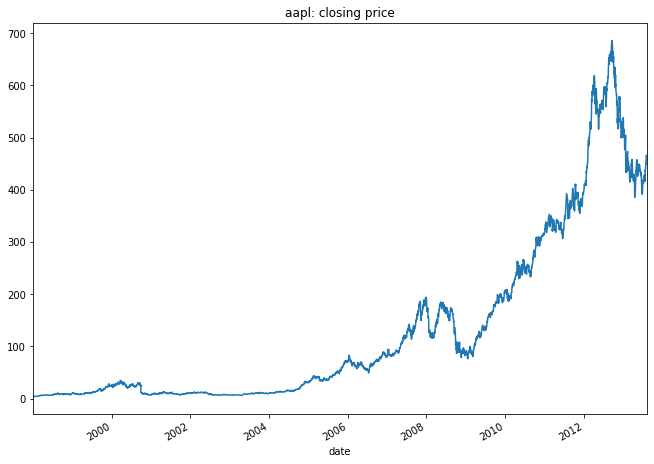

In [39]:
ax = aapl_df.close.plot(figsize=(11, 8))
t = ax.set_title("aapl: closing price")

In [40]:
def plot_time_series_decomposition(series, freq=252):
    res = sm.tsa.seasonal_decompose(series, freq=freq)
    
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(11,8))

    p1 = res.trend.plot(ax=ax1, rot=0)
    t1 = ax1.title.set_text("trend")

    p2 = res.seasonal.plot(ax=ax2, rot=0)
    t2 = ax2.title.set_text("seasonal")

    p3 = res.resid.plot(ax=ax3, rot=0)
    t3 = ax3.title.set_text("resid")
    
    fig.tight_layout()

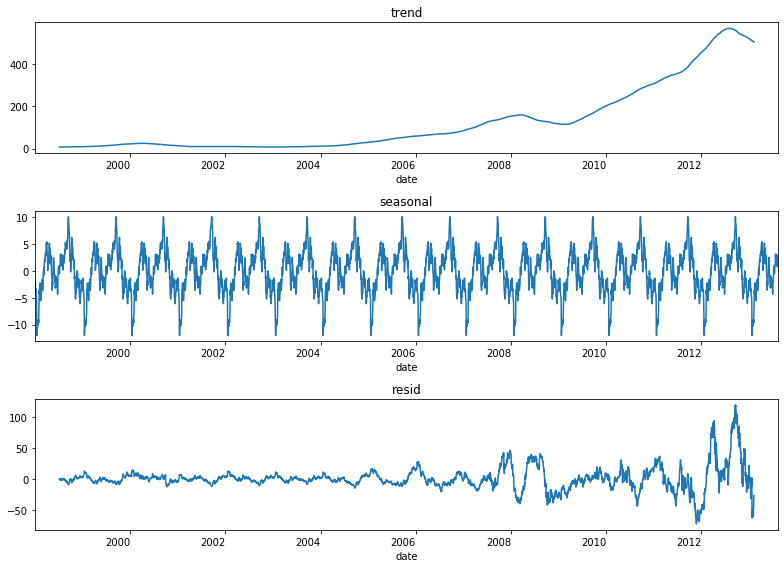

In [41]:
plot_time_series_decomposition(aapl_df.close)

## Returns

In [42]:
aapl_df["return_gross"] = aapl_df.close.divide(aapl_df.close.shift(1))

In [43]:
aapl_df["return_simple"] = aapl_df.return_gross - 1

In [44]:
aapl_df.return_simple.describe()

count    3925.000000
mean        0.001672
std         0.029774
min        -0.518150
25%        -0.013670
50%         0.000859
75%         0.016312
max         0.183749
Name: return_simple, dtype: float64

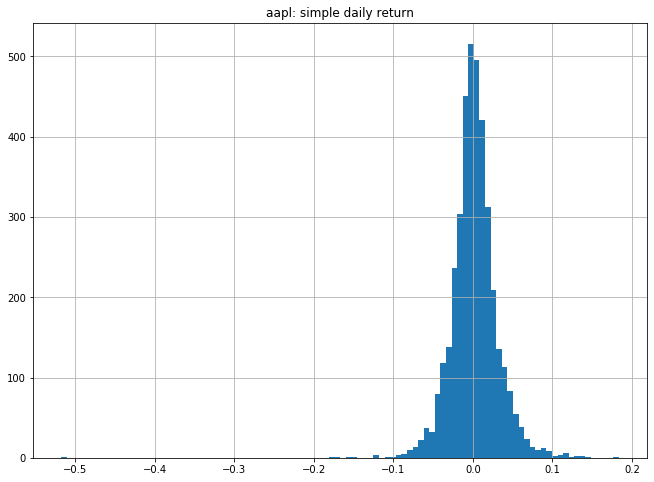

In [45]:
ax = aapl_df.return_simple.hist(figsize=(11, 8), bins=100)

t = ax.set_title("aapl: simple daily return")

In [46]:
aapl_df.return_simple.quantile([0, .01, .05, .1, .25])

0.00   -0.518150
0.01   -0.070870
0.05   -0.042636
0.10   -0.030308
0.25   -0.013670
Name: return_simple, dtype: float64

In [47]:
(aapl_df.return_simple < -.1).sum()

10

In [48]:
aapl_df[aapl_df.return_simple < -.1]

,date,open,high,low_price,close,volume,return_gross,return_simple
date,,,,,,,,
1999-01-14,1999-01-14,11.06280,11.18440,9.98318,10.07560,5.813583e+07,0.892333,-0.107667
1999-09-21,1999-09-21,17.79520,17.80980,16.77650,16.81050,1.138997e+08,0.875187,-0.124813
2000-09-29,2000-09-29,13.64490,14.10200,12.34160,12.52160,2.339738e+08,0.481850,-0.518150
2000-12-06,2000-12-06,7.11421,7.29413,6.80785,6.99264,4.577349e+07,0.845883,-0.154117
2001-07-18,2001-07-18,10.62510,10.69810,9.92974,10.10480,3.854362e+07,0.829214,-0.170786
2002-06-19,2002-06-19,8.44660,8.55844,8.20832,8.33476,5.893970e+07,0.850621,-0.149379
2002-07-17,2002-07-17,7.84362,7.87766,7.38652,7.62479,4.142656e+07,0.878923,-0.121077
2008-01-23,2008-01-23,132.46100,136.15700,122.67700,135.03800,1.181346e+08,0.880185,-0.119815
2008-09-29,2008-09-29,116.41400,116.41400,97.82880,103.12900,9.250666e+07,0.823352,-0.176648


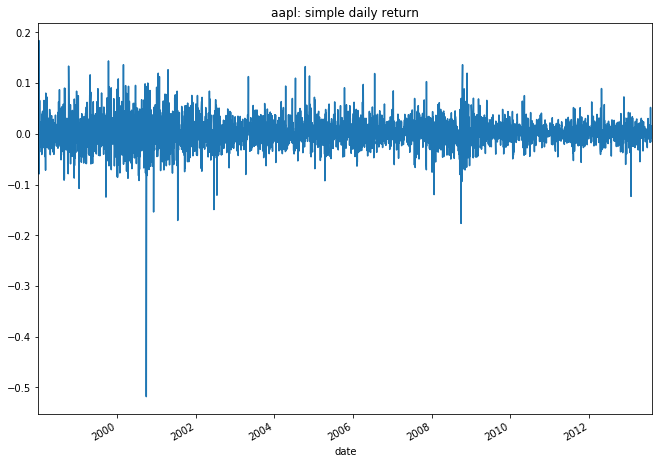

In [49]:
ax = aapl_df.return_simple.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return")

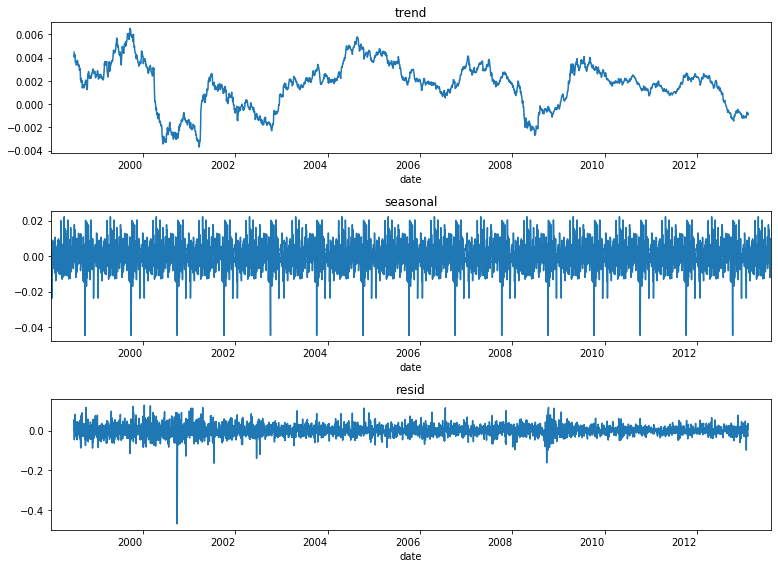

In [50]:
plot_time_series_decomposition(aapl_df.return_simple.dropna())

In [51]:
aapl_df["return_simple_rolling_21_mean"] = aapl_df.return_simple.rolling(21).mean()

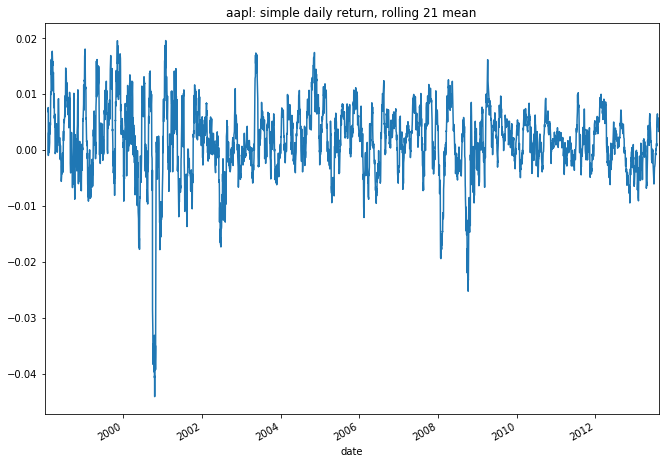

In [52]:
ax = aapl_df.return_simple_rolling_21_mean.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 21 mean")

In [53]:
def set_and_plot_rolling_mean(window):
    col_name = f"return_simple_rolling_{window}_mean"
    aapl_df[col_name] = aapl_df.return_simple.rolling(window).mean()
    
    ax = aapl_df[col_name].plot(figsize=(11, 8))
    t = ax.set_title(f"aapl: simple daily return, rolling {window} day mean")

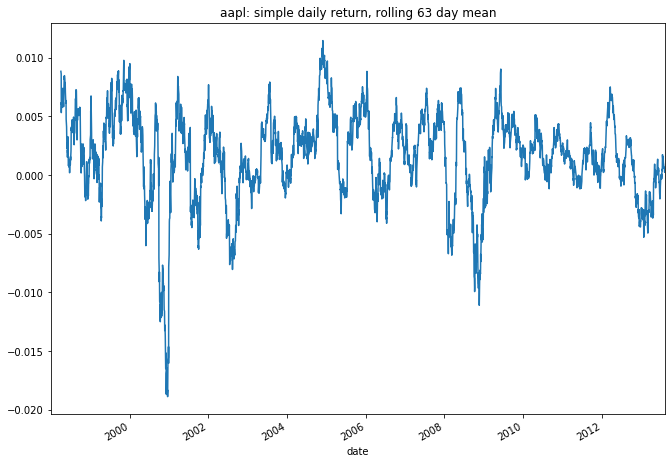

In [54]:
set_and_plot_rolling_mean(63)

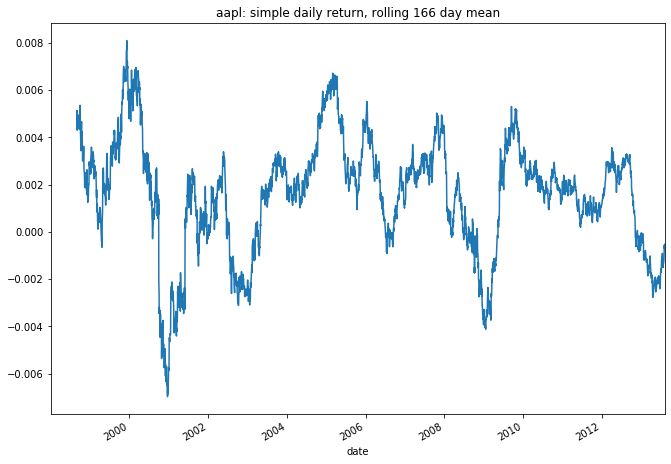

In [55]:
set_and_plot_rolling_mean(166)

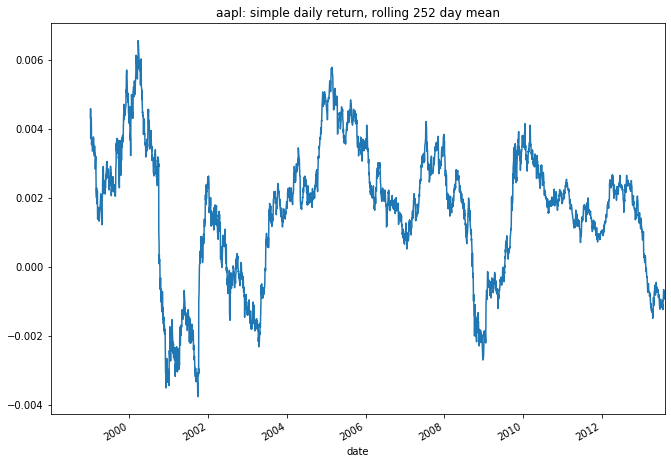

In [56]:
set_and_plot_rolling_mean(252)

In [57]:
aapl_df["return_simple_63_std"] = aapl_df.return_simple.rolling(63).std()

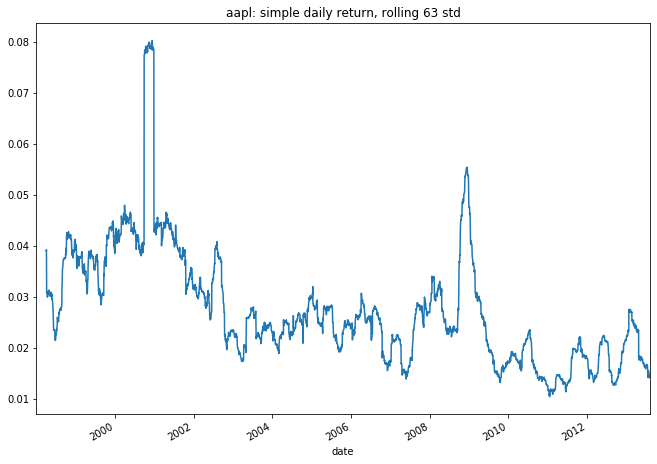

In [58]:
ax = aapl_df.return_simple_63_std.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 63 std")

In [59]:
[c for c in aapl_df.columns if "63" in c]

['return_simple_rolling_63_mean', 'return_simple_63_std']

In [60]:
aapl_quarterly = aapl_df[[c for c in aapl_df.columns if "63" in c]
                        ].dropna()

In [61]:
aapl_quarterly = aapl_quarterly / aapl_quarterly.iloc[0]

In [62]:
aapl_quarterly.iloc[0:5]

,return_simple_rolling_63_mean,return_simple_63_std
date,,
1998-04-03,1.000000,1.000000
1998-04-06,0.973895,1.004831
1998-04-07,0.601837,0.829599
1998-04-08,0.699827,0.788331
1998-04-09,0.681255,0.784945


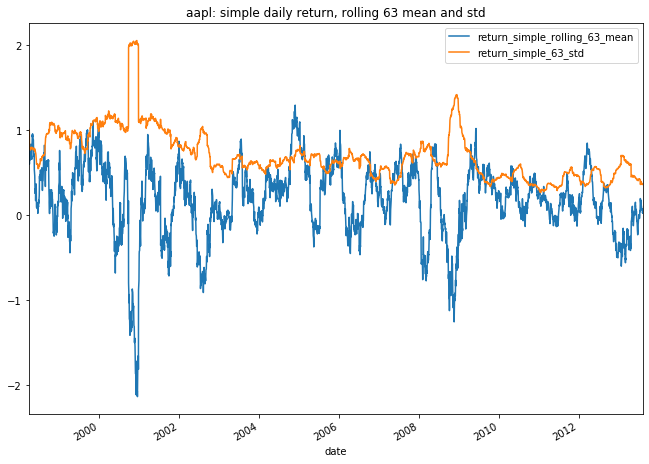

In [63]:
ax = aapl_quarterly.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 63 mean and std")

In [64]:
aapl_quarterly.corr()

,return_simple_rolling_63_mean,return_simple_63_std
return_simple_rolling_63_mean,1.000000,-0.370614
return_simple_63_std,-0.370614,1.000000


In [65]:
aapl_quarterly.iloc[0:5]

,return_simple_rolling_63_mean,return_simple_63_std
date,,
1998-04-03,1.000000,1.000000
1998-04-06,0.973895,1.004831
1998-04-07,0.601837,0.829599
1998-04-08,0.699827,0.788331
1998-04-09,0.681255,0.784945


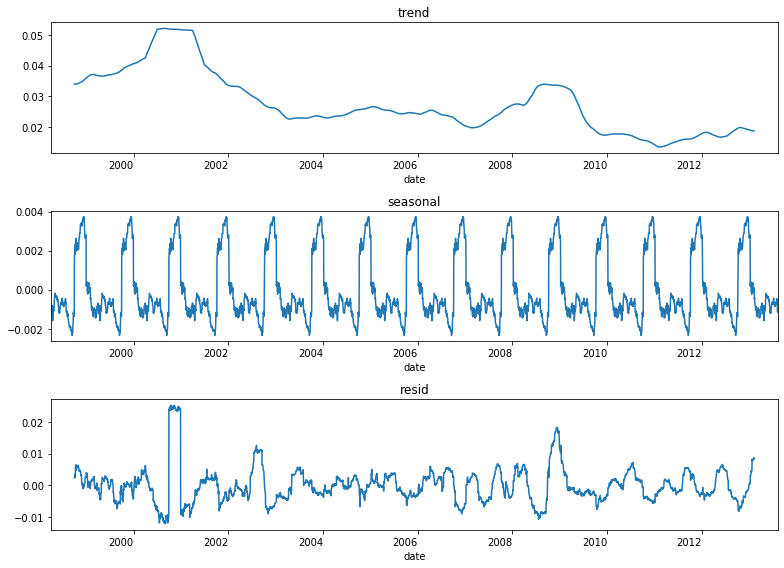

In [66]:
plot_time_series_decomposition(aapl_df.return_simple_63_std.dropna())

In [67]:
aapl_df[["return_simple_rolling_166_mean", "return_simple_63_std"]].corr()

,return_simple_rolling_166_mean,return_simple_63_std
return_simple_rolling_166_mean,1.000000,-0.280703
return_simple_63_std,-0.280703,1.000000


In [68]:
def compare_return_to_vol(return_col, vol_col, df=aapl_df):
    return df[[return_col, vol_col]].corr()

In [69]:
aapl_df.columns

Index(['date', 'open', 'high', 'low_price', 'close', 'volume', 'return_gross',
       'return_simple', 'return_simple_rolling_21_mean',
       'return_simple_rolling_63_mean', 'return_simple_rolling_166_mean',
       'return_simple_rolling_252_mean', 'return_simple_63_std'],
      dtype='object')

In [70]:
compare_return_to_vol("return_simple_rolling_63_mean", "return_simple_63_std")

,return_simple_rolling_63_mean,return_simple_63_std
return_simple_rolling_63_mean,1.000000,-0.370614
return_simple_63_std,-0.370614,1.000000


In [71]:
aapl_df["return_simple_166_std"] = aapl_df.return_simple.rolling(166).std()

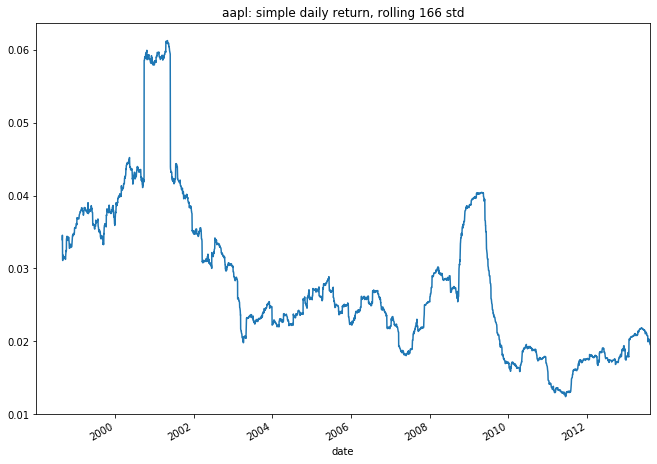

In [72]:
ax = aapl_df.return_simple_166_std.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 166 std")

In [74]:
compare_return_to_vol("return_simple_rolling_166_mean", "return_simple_166_std")

,return_simple_rolling_166_mean,return_simple_166_std
return_simple_rolling_166_mean,1.000000,-0.349501
return_simple_166_std,-0.349501,1.000000


In [77]:
aapl_halflyish = aapl_df[[c for c in aapl_df.columns if "166" in c]
                        ].dropna()

In [78]:
aapl_halflyish = aapl_halflyish / aapl_halflyish.iloc[0]

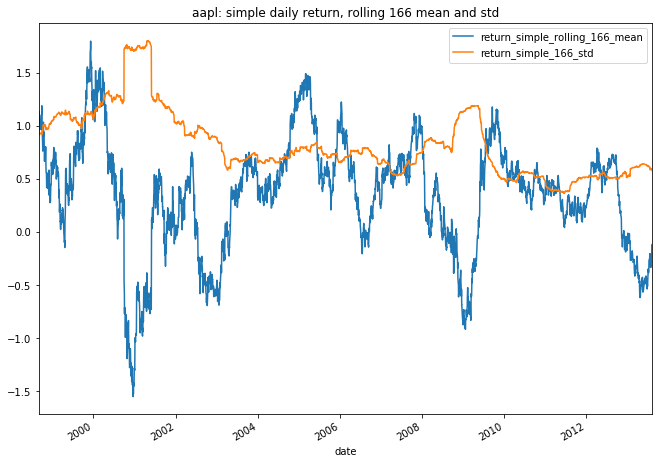

In [79]:
ax = aapl_halflyish.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 166 mean and std")

# 2.Multi-Stock Analysis

In [81]:
len(dfs_list)

500

In [82]:
os.listdir(data_dir)[:5]

['table_a.csv',
 'table_aa.csv',
 'table_aapl.csv',
 'table_abbv.csv',
 'table_abc.csv']

In [83]:
os.listdir(data_dir)[-5:]

['table_xyl.csv',
 'table_yhoo.csv',
 'table_yum.csv',
 'table_zion.csv',
 'table_zmh.csv']

In [84]:
def get_stock_name(csv_name):
    file_name = csv_name.split(".")[0]
    return file_name.split("_")[1]

In [85]:
dfs_list_indexed = [
    pd.concat(
        {
            get_stock_name(csv_name): dfs_list[i]
        }, axis=1)
    for i, csv_name in enumerate(stock_csv_names)
]

In [87]:
all_stocks = dfs_list_indexed[0].join(dfs_list_indexed[1:])

In [88]:
all_stocks.iloc[:5, :8]

a                                                     \
                 date     open     high low_price    close        volume   
date                                                                       
1999-11-18 1999-11-18  42.2076  46.3820   37.4581  39.1928  4.398181e+07   
1999-11-19 1999-11-19  39.8329  39.8885   36.9293  37.6251  1.139020e+07   
1999-11-22 1999-11-22  38.3208  40.0091   37.1613  39.9442  4.654716e+06   
1999-11-23 1999-11-23  39.4247  40.4729   37.3375  37.5138  4.268903e+06   
1999-11-24 1999-11-24  37.2262  38.9052   37.1056  38.0889  3.602367e+06   

                   aa           
                 date     open  
date                            
1999-11-18 1999-11-18  24.5183  
1999-11-19 1999-11-19  24.5647  
1999-11-22 1999-11-22  24.6846  
1999-11-23 1999-11-23  25.0018  
1999-11-24 1999-11-24  25.0482

In [89]:
all_stocks["a"].head()

,date,open,high,low_price,close,volume
date,,,,,,
1999-11-18,1999-11-18,42.2076,46.3820,37.4581,39.1928,4.398181e+07
1999-11-19,1999-11-19,39.8329,39.8885,36.9293,37.6251,1.139020e+07
1999-11-22,1999-11-22,38.3208,40.0091,37.1613,39.9442,4.654716e+06
1999-11-23,1999-11-23,39.4247,40.4729,37.3375,37.5138,4.268903e+06
1999-11-24,1999-11-24,37.2262,38.9052,37.1056,38.0889,3.602367e+06


### close

In [90]:
all_stocks["a"]["close"].head()

date
1999-11-18    39.1928
1999-11-19    37.6251
1999-11-22    39.9442
1999-11-23    37.5138
1999-11-24    38.0889
Name: close, dtype: float64

In [91]:
tickers = all_stocks.columns.levels[0]

In [92]:
tickers[:5]

Index(['a', 'aa', 'aapl', 'abbv', 'abc'], dtype='object')

In [93]:
_all_close_list = [all_stocks[tick].close for tick in tickers]

In [94]:
_all_close_list[0].head()

date
1999-11-18    39.1928
1999-11-19    37.6251
1999-11-22    39.9442
1999-11-23    37.5138
1999-11-24    38.0889
Name: close, dtype: float64

In [95]:
_all_close_list = [srs.rename(tickers[i])
                  for i, srs in enumerate(_all_close_list)]

In [96]:
all_stocks_close = _all_close_list[0].to_frame().join(_all_close_list[1:])

In [97]:
all_stocks_close.iloc[:5, :8]

,a,aa,aapl,abbv,abc,abt,ace,acn
date,,,,,,,,
1999-11-18,39.1928,24.2514,21.7924,NaN,3.09830,11.9023,14.3008,NaN
1999-11-19,37.6251,24.6846,22.4756,NaN,3.05589,11.8612,13.9294,NaN
1999-11-22,39.9442,25.0250,22.0185,NaN,2.95767,12.2375,14.0259,NaN
1999-11-23,37.5138,25.2185,22.6264,NaN,2.74784,12.0383,13.9294,NaN
1999-11-24,38.0889,24.9283,23.0373,NaN,2.74784,12.1964,13.3722,NaN


In [98]:
all_stocks_returns = all_stocks_close / all_stocks_close.shift(1)

### correlation

In [99]:
corrs = all_stocks_returns.corr()

In [100]:
corrs.iloc[:5, :5]

,a,aa,aapl,abbv,abc
a,1.000000,0.383146,0.361200,0.164908,0.169508
aa,0.383146,1.000000,0.283109,0.067920,0.254100
aapl,0.361200,0.283109,1.000000,0.032483,0.142794
abbv,0.164908,0.067920,0.032483,1.000000,0.282846
abc,0.169508,0.254100,0.142794,0.282846,1.000000


In [101]:
corrs_modified = corrs.replace(1, np.nan)

In [102]:
corrs_modified.iloc[:5, :5]

,a,aa,aapl,abbv,abc
a,NaN,0.383146,0.361200,0.164908,0.169508
aa,0.383146,NaN,0.283109,0.067920,0.254100
aapl,0.361200,0.283109,NaN,0.032483,0.142794
abbv,0.164908,0.067920,0.032483,NaN,0.282846
abc,0.169508,0.254100,0.142794,0.282846,NaN


In [103]:
corrs_modified.max().sort_values(ascending=False)[:5]

eqr    0.884192
avb    0.884192
spg    0.883757
bxp    0.883757
vno    0.883234
dtype: float64

In [104]:
corrs_modified.min().sort_values(ascending=False)[:5]

wyn    0.178355
pfg    0.175845
dfs    0.175066
dd     0.168540
hst    0.159443
dtype: float64

In [105]:
_all_open_list = [all_stocks[tick].open for tick in tickers]

In [106]:
_all_open_list[0].head()

date
1999-11-18    42.2076
1999-11-19    39.8329
1999-11-22    38.3208
1999-11-23    39.4247
1999-11-24    37.2262
Name: open, dtype: float64

In [107]:
_all_open_list = [srs.rename(tickers[i])
                  for i, srs in enumerate(_all_open_list)]

In [108]:
all_stocks_open = _all_open_list[0].to_frame().join(_all_open_list[1:])

In [109]:
all_stocks_open.iloc[:5, :8]

,a,aa,aapl,abbv,abc,abt,ace,acn
date,,,,,,,,
1999-11-18,42.2076,24.5183,22.1401,NaN,2.88847,12.1775,14.8134,NaN
1999-11-19,39.8329,24.5647,21.7608,NaN,3.08267,12.0003,14.3973,NaN
1999-11-22,38.3208,24.6846,22.3079,NaN,3.01348,12.0193,14.0259,NaN
1999-11-23,39.4247,25.0018,22.3079,NaN,2.95767,12.1585,14.2116,NaN
1999-11-24,37.2262,25.0482,22.6118,NaN,2.73445,12.0794,13.8848,NaN


In [110]:
mean_spread = (all_stocks_close - all_stocks_open
     ).mean(axis=1
     )

In [111]:
mean_spread.head()

date
1999-11-18    0.029497
1999-11-19   -0.136570
1999-11-22   -0.136851
1999-11-23   -0.344567
1999-11-24    0.187926
dtype: float64

In [112]:
mean_spread = mean_spread.rename("mean_spread")

In [113]:
std_spread = (all_stocks_close - all_stocks_open
     ).std(axis=1
     )

In [114]:
std_spread.head()

date
1999-11-18    1.447925
1999-11-19    2.082665
1999-11-22    1.295058
1999-11-23    2.393124
1999-11-24    1.648351
dtype: float64

In [115]:
std_spread = std_spread.rename("std_spread")

In [116]:
joined_spread = mean_spread.to_frame().join(std_spread)

In [117]:
joined_spread = joined_spread / joined_spread.iloc[0]

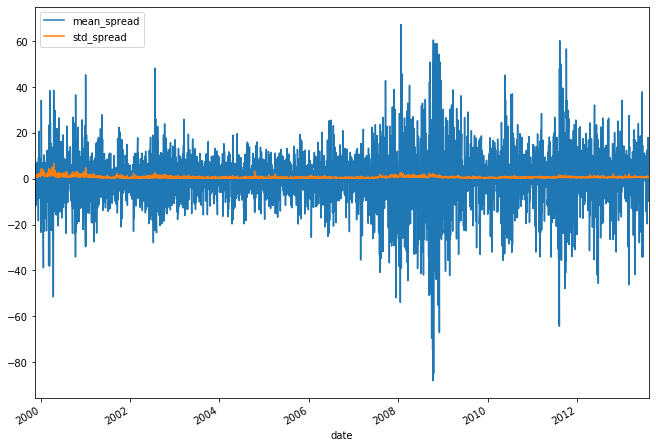

In [118]:
ax = joined_spread.plot(figsize=(11, 8))

# 3. Returns, by month

## Average daily return, by month

In [120]:
aapl_df["month"] = aapl_df.date.apply(lambda d: d.month)

In [121]:
daily_by_month = aapl_df[["month", "return_simple"]
                         ].groupby("month"
                         ).agg([np.mean, np.std])

In [122]:
daily_by_month

return_simple          
               mean       std
month                        
1          0.002190  0.034613
2          0.001037  0.025793
3          0.003630  0.027720
4          0.002755  0.030354
5         -0.000095  0.025757
6          0.000647  0.024897
7          0.003089  0.030554
8          0.001921  0.023400
9         -0.000956  0.042424
10         0.003242  0.033829
11         0.001369  0.028624
12         0.000834  0.025551

In [123]:
daily_by_month.columns = daily_by_month.columns.droplevel()

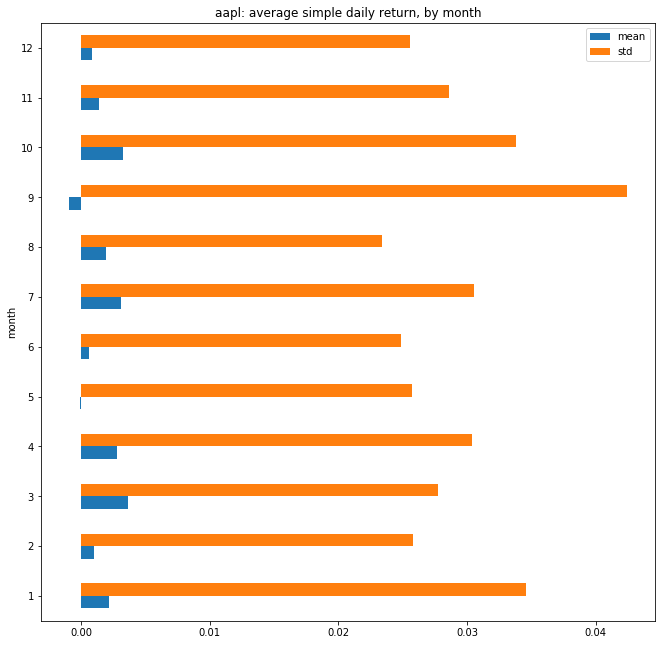

In [124]:
ax = daily_by_month.plot.barh(figsize=(11, 11))

t = ax.set_title("aapl: average simple daily return, by month")

## Average monthly return by month

In [146]:
aapl_df['year'] = aapl_df.date.apply(lambda d: d.year)

In [147]:
monthly_by_month = aapl_df[["year", "month", "return_simple"]
                         ].groupby(["year", "month"]
                         ).agg([np.amin, np.amax])

In [148]:
monthly_by_month = monthly_by_month.diff(axis = 1)

In [150]:
monthly_by_month.columns = monthly_by_month.columns.swaplevel()

In [152]:
monthly_by_month = monthly_by_month["amax"]

In [153]:
monthly_by_month.head()

return_simple
year month               
1998 1           0.262945
     2           0.106502
     3           0.151977
     4           0.089050
     5           0.076243

In [154]:
monthlies = monthly_by_month.groupby(level=1
                      ).agg([np.mean, np.std])

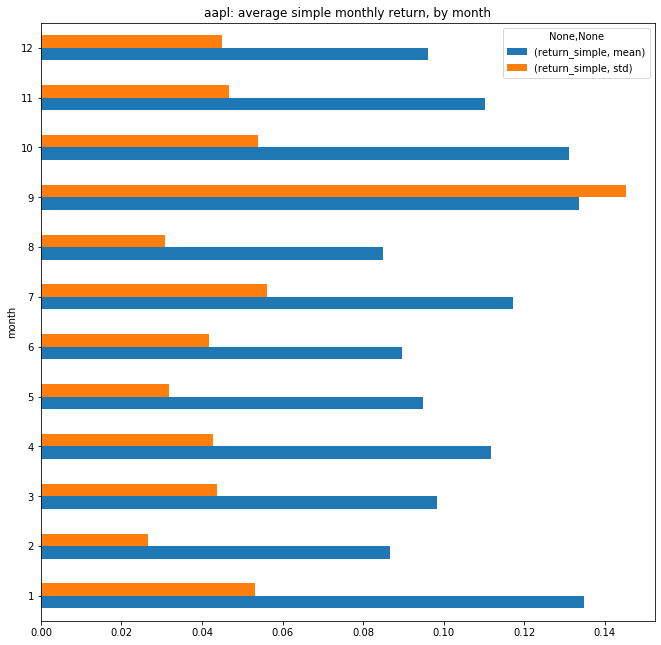

In [155]:
ax = monthlies.plot.barh(figsize=(11, 11))

t = ax.set_title("aapl: average simple monthly return, by month")

# 4. Autocorrelation

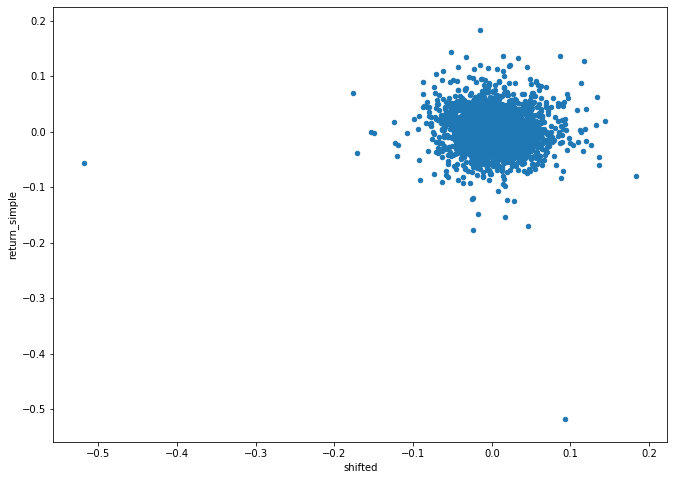

In [156]:
ax = aapl_df.return_simple.to_frame(
            ).join(
                aapl_df.return_simple.shift(1).rename("shifted")
            ).plot.scatter(x="shifted", y="return_simple", figsize=(11, 8))

In [158]:
t_and_t_plus_one = aapl_df.return_simple.to_frame(
                        ).join(
                            aapl_df.return_simple.shift(1).rename('shifted')
                        )

In [159]:
(t_and_t_plus_one < -.5).sum()

return_simple    1
shifted          1
dtype: int64

In [160]:
for col in t_and_t_plus_one.columns:
    t_and_t_plus_one.loc[t_and_t_plus_one[col] < -.5, col] = np.nan

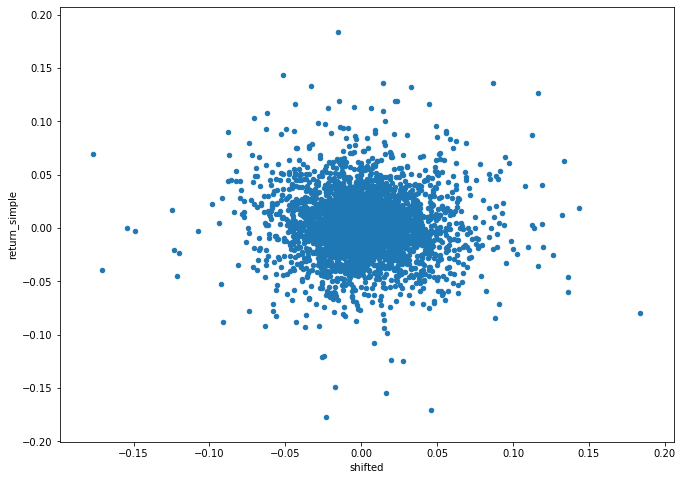

In [161]:
ax = t_and_t_plus_one.plot.scatter(x="shifted", y="return_simple", figsize=(11, 8))

In [162]:
aapl_autocorrs = pd.Series({
            lag: aapl_df.return_simple.autocorr(lag=lag) for lag in list(range(1, 20))
            })

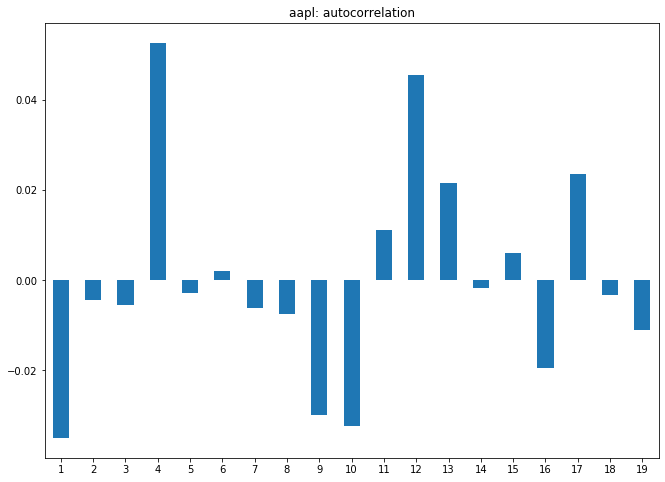

In [163]:
ax = aapl_autocorrs.plot.bar(figsize=(11, 8), rot=0)

t = ax.title.set_text("aapl: autocorrelation")

In [167]:
aapl_df["weekday"] = aapl_df.date.apply(lambda d: d.weekday())

In [168]:
aapl_df.weekday.value_counts(normalize=True).sort_index()

0    0.187723
1    0.204534
2    0.205807
3    0.201732
4    0.200204
Name: weekday, dtype: float64

In [166]:
aapl_df[aapl_df.weekday == 4].return_simple.head()

date
1998-01-02         NaN
1998-01-09    0.010519
1998-01-16   -0.022928
1998-01-23    0.009838
1998-01-30   -0.009699
Name: return_simple, dtype: float64

In [169]:
aapl_df[aapl_df.weekday == 4].return_simple.autocorr(lag=1)

0.06890856162364511

In [170]:
for w in sorted(aapl_df.weekday.unique()):
    print(w, aapl_df[aapl_df.weekday == w].return_simple.autocorr(lag=1), sep=": ")

0: 0.03307978683299217
1: 0.02142547271905113
2: 0.01132272930404902
3: -0.025362416692087088
4: 0.06890856162364511


## Correlations, with rolling window returns

In [171]:
aapl_df.return_simple.to_frame(
                    ).join(
                        aapl_df.return_simple_rolling_21_mean.shift(1)
                    ).corr()

,return_simple,return_simple_rolling_21_mean
return_simple,1.000000,-0.004471
return_simple_rolling_21_mean,-0.004471,1.000000


In [172]:
aapl_df.return_simple.to_frame(
                    ).join(
                        aapl_df.return_simple_rolling_63_mean.shift(1)
                    ).corr()

,return_simple,return_simple_rolling_63_mean
return_simple,1.00000,0.01565
return_simple_rolling_63_mean,0.01565,1.00000


# 5. Log returns

In [173]:
aapl_df["close_log"] = aapl_df.close.apply(np.log)

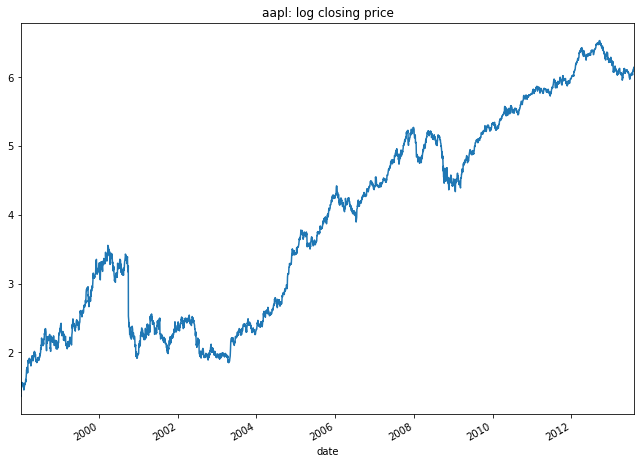

In [174]:
ax = aapl_df.close_log.plot(figsize=(11, 8))
t = ax.set_title("aapl: log closing price")

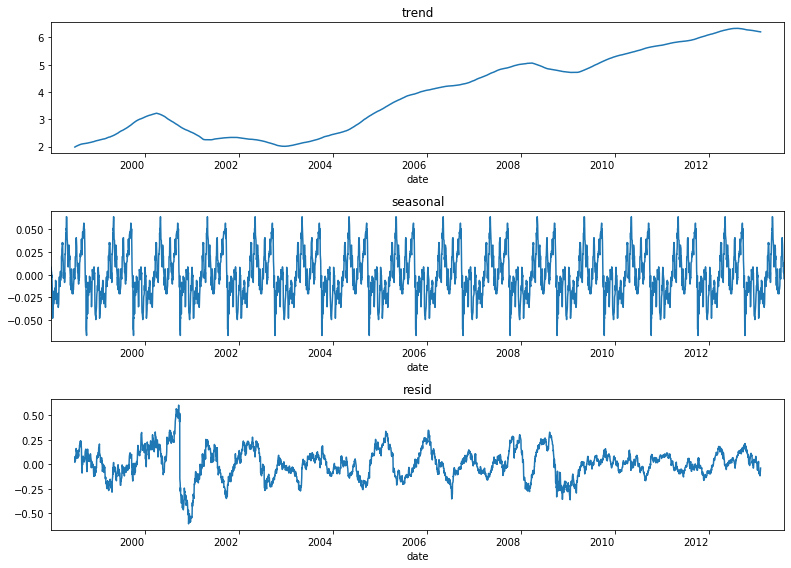

In [175]:
plot_time_series_decomposition(aapl_df.close_log)

In [176]:
aapl_df["return_log"] = aapl_df.close_log - aapl_df.close_log.shift(1)

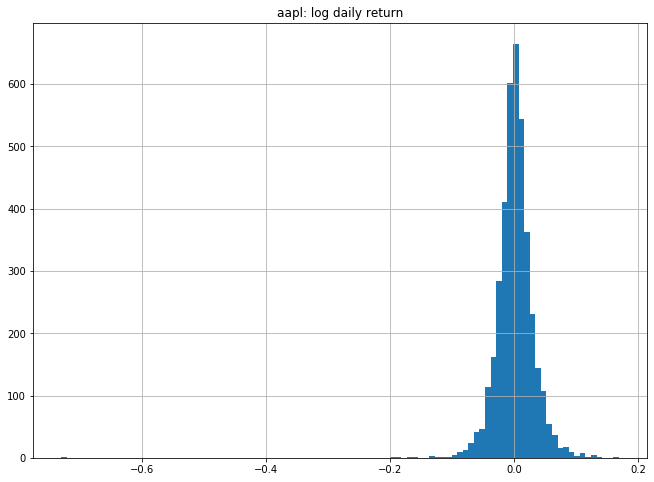

In [177]:
ax = aapl_df.return_log.hist(figsize=(11, 8), bins=100)

t = ax.set_title("aapl: log daily return")

In [178]:
aapl_df.return_simple.skew()

-1.198448451367238

In [179]:
aapl_df.return_log.skew()

-3.4413935608928203

In [180]:
aapl_df["return_cubrt"] = aapl_df.return_simple.apply(np.cbrt)

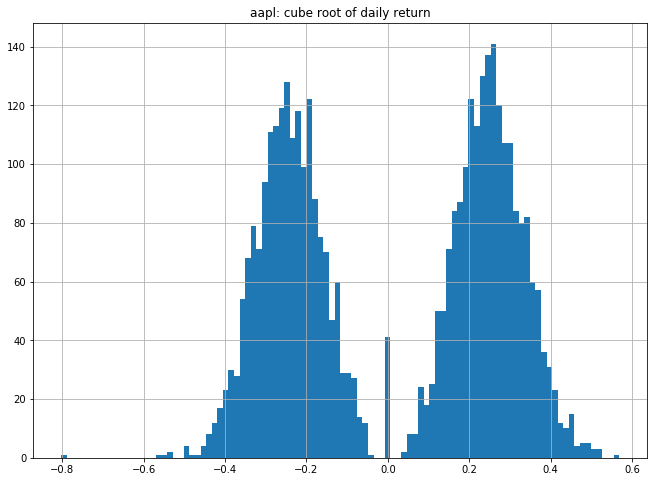

In [181]:
ax = aapl_df.return_cubrt.hist(figsize=(11, 8), bins=100)

t = ax.set_title("aapl: cube root of daily return")

In [182]:
aapl_df["day_of_week"] = aapl_df.date.apply(lambda d: d.weekday())

In [183]:
aapl_df.day_of_week.value_counts(normalize = True).sort_index()

0    0.187723
1    0.204534
2    0.205807
3    0.201732
4    0.200204
Name: day_of_week, dtype: float64

In [184]:
aapl_df["is_monday"] = aapl_df.day_of_week == 0

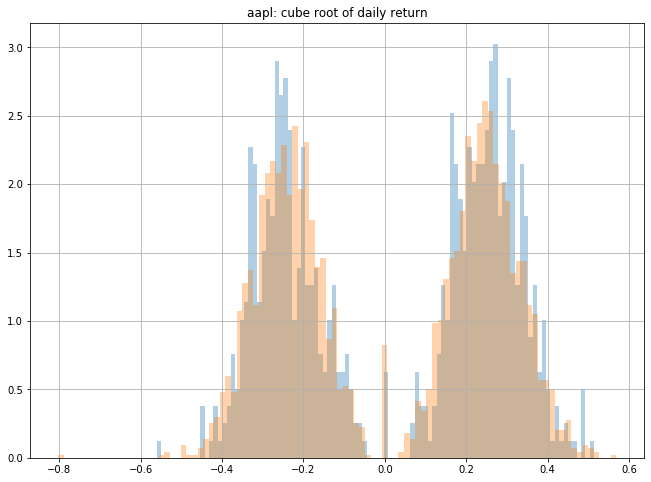

In [185]:
ax = aapl_df.loc[aapl_df.is_monday == True, "return_cubrt"].hist(
                    figsize=(11, 8), bins=100, density=True, alpha=.35)

ax = aapl_df.loc[aapl_df.is_monday == False, "return_cubrt"].hist(ax=ax, alpha=.35, bins=100, density=True)

t = ax.set_title("aapl: cube root of daily return")

In [186]:
aapl_df[["return_simple", "is_monday"]].groupby("is_monday").agg([np.mean, np.std])

return_simple          
                   mean       std
is_monday                        
False          0.001286  0.029905
True           0.003341  0.029161

# 6. Autoregression

In [187]:
aapl_returns_2010 = aapl_df.loc[aapl_df.date.apply(lambda d: d.year == 2010), "return_simple"]

In [188]:
train = aapl_returns_2010.loc[:datetime.date(2010, 6, 30)]

In [189]:
train.head()

date
2010-01-04    0.016518
2010-01-05    0.000701
2010-01-06   -0.016521
2010-01-07   -0.001990
2010-01-08    0.007175
Name: return_simple, dtype: float64

In [190]:
train.tail()

date
2010-06-24   -0.006807
2010-06-25   -0.005433
2010-06-28    0.005089
2010-06-29   -0.044515
2010-06-30   -0.020156
Name: return_simple, dtype: float64

In [191]:
test = aapl_returns_2010.loc[datetime.date(2010, 7, 1):datetime.date(2010, 7, 31)]

In [192]:
model = AR(train.values)

In [193]:
model_fit = model.fit()

In [194]:
model_fit.k_ar

13

In [195]:
model_fit.params

array([ 0.00246467,  0.04125616,  0.03683962, -0.25484031,  0.04155076,
        0.09983197, -0.17533004, -0.02235045, -0.07667173, -0.08510721,
       -0.01421416, -0.03022782,  0.04335507,  0.29210439])

In [196]:
params_df = pd.DataFrame(model_fit.params,
                         index=[i for i in range(len(model_fit.params))],
                         columns=["model_params"])

In [197]:
autocorrs = aapl_autocorrs.rename("autocorr").loc[:13].to_frame()

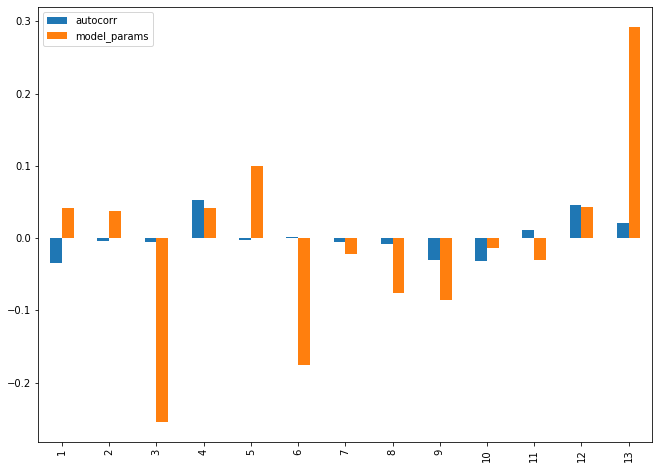

In [198]:
ax = autocorrs.join(params_df).plot.bar(figsize=(11, 8))

In [199]:
predictions = model_fit.predict(start=len(train),
                                end=len(train) + len(test) -1,
                                dynamic=False)

In [200]:
predictions_df = pd.DataFrame(predictions, index=test.index, columns=["predicted"])

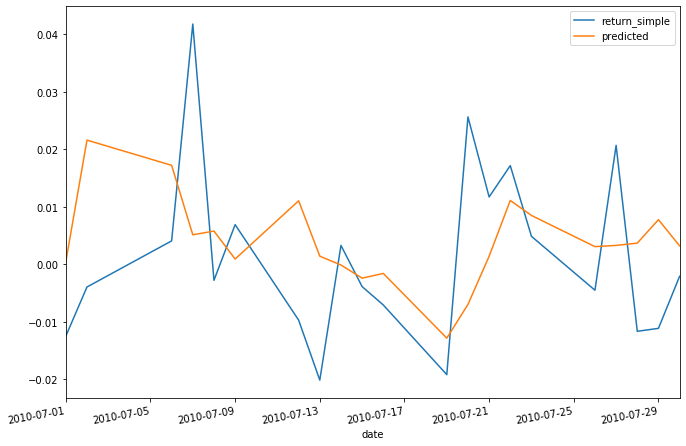

In [201]:
ax = test.to_frame().join(predictions_df).plot(figsize=(11, 8), rot=10)